# Assignment #3


Natural Language Processing / Iran University of Science and Technology



---



**Please pay attention to these notes:**

<br/>

- **Assignment Due:** 1398/11/7 23:59
- The items you need to answer are highlighted in red and the coding parts you need to implement are denoted by:
```
########################################
#     Put your implementation here     #
########################################
```
- We always recommend co-operation and discussion in groups for assignments. However, each student has to finish all the questions by him/herself. So, please mention his/her name if you have a team-mate.
- Finding any sort of copying will zero down that assignment grade.
- When your solution is ready to submit, don't forget to set the name of this notebook like  "Name_StudentID.ipynb".
- If you have any questions about this assignment, feel free to drop us a line. You can also ask your questions on the telegram group.
- You must run this notebook on Google Colab platform; there are some dependencies to Google Colab VM for some of the libraries.

<br/>



# 1. Question Answering Systems

Two grand challenges in artificial intelligence research have been to build models that can make multiple computational steps in the Question Answering systems or completing a task, and models that can learn and describe long term dependencies in sequential data.

## 1.1 Question Answering System with the use of Memory Networks

In this task we want to work on a simple presented QA system. The continuity of the model we present here means that it can be trained end to-end from input-output pairs, and so is applicable to more tasks, i.e. tasks where such supervision is not available, such as in language modeling or realistically supervised question answering tasks.

Imports:

In [0]:
import keras
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM, GRU
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K

from functools import reduce
import tarfile
import numpy as np
import re

import IPython
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

Using TensorFlow backend.


## 1.2 Preprocessing

We will use a dataset consists of questions where a previously given single supporting fact, potentially amongst a set of other irrelevant facts, provides the answer. We first test one of the simplest cases of this, by asking for the location of a person, e.g. “$Mary$ $travelled$ $to$ $the$ $office.$ $Where$ $is$ $Mary?$”. It can be considered the
simplest case of some real world QA datasets.

About the dataset: https://research.fb.com/downloads/babi/

Lets download the dataset:

In [0]:
try:
    path = get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
except:
    print('Error downloading dataset, please download it manually:\n'
          '$ wget http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2.tar.gz\n'
          '$ mv tasks_1-20_v1-2.tar.gz ~/.keras/datasets/babi-tasks-v1-2.tar.gz')
    raise
tar = tarfile.open(path)

11747328/11745123 [==============================] - 0s 0us/step


Our model takes a discrete set of inputs $x_{1}, ..., x_{n}$ that are to be stored in the memory, a query $q$, and outputs an answer $a$. Each of the $x_{i}$, $q$, and $a$ contains symbols coming from a dictionary with $V$ words. The model writes all $x$ to the memory up to a fixed buffer size, and then finds a continuous representation for the $x$ and $q$. The continuous representation is then processed via multiple hops to
output $a$. This allows backpropagation of the error signal through multiple memory accesses back to the input during training. The overall model is shown in the next figure. During training, all three embedding matrices $A, B$ and $C$, as well as $W$ are jointly learned by minimizing a standard cross-entropy loss between $aˆ$ and the true
label $a$. Training is performed using stochastic gradient descent.


Delve more deeply into the details: https://arxiv.org/pdf/1503.08895.pdf

<p align="center"><img src="https://cdn-21.anonfile.com/T9j89eK4n4/90735f05-1577960396/outview%20of%20model.jpg" width="800"/>   
</p>


Write some helper functions:

In [0]:
def tokenize(sent):
    return [ x.strip() for x in re.split('(\W+)?', sent) if x.strip()]


According to the dataset (bAbi tasks), we need to prepare the data for training the model. With the next function we parse the dataset and manufactore it in desired way.

In [0]:
def parse_stories(lines, only_supporting=False):
    '''Parse stories provided in the bAbi tasks format
    If only_supporting is true, only the sentences
    that support the answer are kept.
    '''
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            q = tokenize(q)
            substory = None
            if only_supporting:
                # Only select the related substory
                supporting = map(int, supporting.split())
                substory = [story[i - 1] for i in supporting]
            else:
                # Provide all the substories
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            sent = tokenize(line)
            story.append(sent)
    return data


Now we need to take proper structure of the data: 

In [0]:
def get_stories(f, only_supporting=False, max_length=None):
    data = parse_stories(f.readlines(), only_supporting=only_supporting)
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    data = [(flatten(story), q, answer) for story, q, answer in data if not max_length or len(flatten(story)) < max_length]
    return data

Here we need to make the vectors of stories, questions and answers. its too easy:

In [0]:
def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
  inputs_train = []
  queries_train = []
  answers_train = []

  for story, query, answer in data:
    inputs_train.append([word_idx[token] for token in story])
    queries_train.append([word_idx[token] for token in query])
    oh = np.zeros(len(word_idx) + 1)
    oh[word_idx[answer]] = 1
    answers_train.append(oh)

    
  inputs_train = pad_sequences(inputs_train, maxlen=story_maxlen)
  queries_train = pad_sequences(queries_train, maxlen=query_maxlen)

  return np.array(inputs_train),np.array(queries_train), np.array(answers_train)


Its time to extract stories from the dataset, then pass them to the defined functions for parsing and make it usable:

In [0]:
challenges = {
    # QA1 with 10,000 samples
    'single_supporting_fact_10k': 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt',
    # QA2 with 10,000 samples
    'two_supporting_facts_10k': 'tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_{}.txt',
}
challenge_type = 'single_supporting_fact_10k'
challenge = challenges[challenge_type]

print('Extracting stories for the challenge:', challenge_type)
train_stories = get_stories(tar.extractfile(challenge.format('train')))
test_stories = get_stories(tar.extractfile(challenge.format('test')))

Extracting stories for the challenge: single_supporting_fact_10k


/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [0]:
len(train_stories), len(test_stories)

(10000, 1000)

## 1.3 Check our helper functions and prepare the data:

In [0]:
vocab = set()
for story, q, answer in train_stories + test_stories:
    vocab |= set(story + q + [answer])
vocab = sorted(vocab)

# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
story_maxlen = max(map(len, (x for x, _, _ in train_stories + test_stories)))
query_maxlen = max(map(len, (x for _, x, _ in train_stories + test_stories)))

In [0]:
story_maxlen, query_maxlen

(68, 4)

In [0]:
print('-')
print('Vocab size:', vocab_size, 'unique words')
print('Story max length:', story_maxlen, 'words')
print('Query max length:', query_maxlen, 'words')
print('Number of training stories:', len(train_stories))
print('Number of test stories:', len(test_stories))
print('-')
print('Here\'s what a "story" tuple looks like (input, query, answer):')
print(train_stories[0])
print('-')
print('Vectorizing the word sequences...')

word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
idx_word = dict((i+1, c) for i,c in enumerate(vocab))
inputs_train, queries_train, answers_train = vectorize_stories(train_stories,
                                                               word_idx,
                                                               story_maxlen,
                                                               query_maxlen)
inputs_test, queries_test, answers_test = vectorize_stories(test_stories,
                                                            word_idx,
                                                            story_maxlen,
                                                            query_maxlen)


-
Vocab size: 22 unique words
Story max length: 68 words
Query max length: 4 words
Number of training stories: 10000
Number of test stories: 1000
-
Here's what a "story" tuple looks like (input, query, answer):
(['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'John', 'went', 'to', 'the', 'hallway', '.'], ['Where', 'is', 'Mary', '?'], 'bathroom')
-
Vectorizing the word sequences...


In [0]:
inputs_train.shape, queries_train.shape, answers_train.shape

((10000, 68), (10000, 4), (10000, 22))

In [0]:
print('-')
print('inputs: integer tensor of shape (samples, max_length)')
print('inputs_train shape:', inputs_train.shape)
print('inputs_test shape:', inputs_test.shape)
print('-')
print('queries: integer tensor of shape (samples, max_length)')
print('queries_train shape:', queries_train.shape)
print('queries_test shape:', queries_test.shape)
print('-')
print('answers: binary (1 or 0) tensor of shape (samples, vocab_size)')
print('answers_train shape:', answers_train.shape)
print('answers_test shape:', answers_test.shape)
print('-')
print('Compiling...')


-
inputs: integer tensor of shape (samples, max_length)
inputs_train shape: (10000, 68)
inputs_test shape: (1000, 68)
-
queries: integer tensor of shape (samples, max_length)
queries_train shape: (10000, 4)
queries_test shape: (1000, 4)
-
answers: binary (1 or 0) tensor of shape (samples, vocab_size)
answers_train shape: (10000, 22)
answers_test shape: (1000, 22)
-
Compiling...


In this part you should implement 2 functions which illustrate the procedure of learning, Loss and Accuracy. These functions take two inputs: 
* The history of your designed model 
* Proper title for describing the plot

In [0]:
# !pip install plot_keras_history
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

def plot_acc(history, title):
  
  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title(title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Valid'], loc='upper left')
  plt.show()

In [0]:
def plot_loss(history, title):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Valid'], loc='upper left')
  plt.show()

Define model's hyperparameters

In [0]:
train_epochs = 10
batch_size = 32
lstm_size = 64

## 1.4 Implementstion:

Let's build the model. You should use Keras framework. The summary and outview of the right model is saved in the next cells to help you create the proper model faster.


In [0]:
# define the model: 

input_sequence = Input((story_maxlen,))
question = Input((query_maxlen,))


sequential_4 = Sequential()
sequential_4.add(Embedding(input_dim=vocab_size, output_dim=64))
sequential_4 = sequential_4(input_sequence)
print(sequential_4.shape)

sequential_5 = Sequential()
sequential_5.add(Embedding(input_dim=vocab_size, output_dim=4))
sequential_5 = sequential_5(input_sequence)
print(sequential_4.shape)

sequential_6 = Sequential()
sequential_6.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=4))
sequential_6 = sequential_6(question)
print(sequential_6.shape)


# dot ((?, 68, 4), (?, 4, 64))
dot_2 = dot([sequential_4, sequential_6], axes=-1)
dot_2 = Activation('softmax')(dot_2)
print(dot_2.shape)


# add((?, 4,64), (?, 68,64))
add_2 = add([dot_2, sequential_5])
permute_2 = Permute((2, 1))(add_2) 

concatenate_2 = concatenate([permute_2, sequential_6])

lstm_2 = LSTM(32)(concatenate_2) 
dropout_8 = Dropout(0.5)(lstm_2)
dense_2 = Dense(vocab_size)(dropout_8)

activation_4 = Activation('softmax')(dense_2)
answer = activation_4


(?, 68, 64)
(?, 68, 64)
(?, 4, 64)
(?, 68, 4)


In [0]:
# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

This is the correct model:

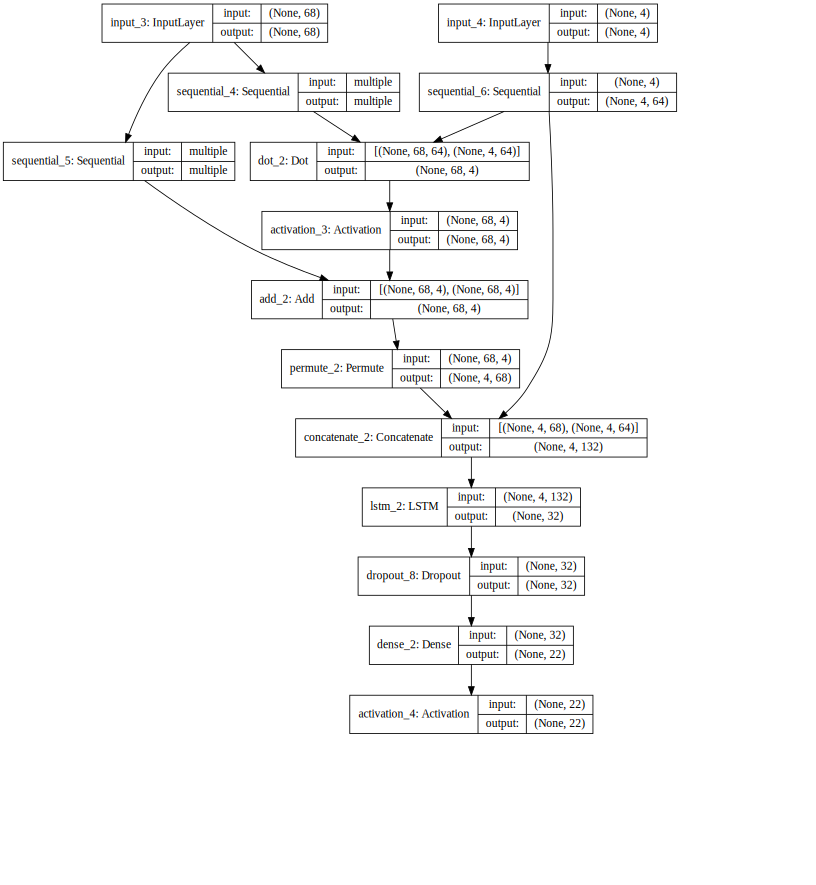

In [0]:
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(model,show_shapes= True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))

Model summary

In [0]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_99 (InputLayer)           (None, 68)           0                                            
__________________________________________________________________________________________________
input_100 (InputLayer)          (None, 4)            0                                            
__________________________________________________________________________________________________
sequential_140 (Sequential)     multiple             1408        input_99[0][0]                   
__________________________________________________________________________________________________
sequential_142 (Sequential)     (None, 4, 64)        1408        input_100[0][0]                  
____________________________________________________________________________________________

In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 68)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       multiple             1408        input_3[0][0]                    
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 4, 64)        1408        input_4[0][0]                    
____________________________________________________________________________________________

## 1.5 Training

In this section we start the training procedure with fitting the data to the designed model.

Train on 10000 samples, validate on 1000 samples
Epoch 1/10
10000/10000 [==============================] - 4s 438us/step - loss: 1.3196 - acc: 0.4938 - val_loss: 1.3174 - val_acc: 0.4990
Epoch 2/10
10000/10000 [==============================] - 4s 426us/step - loss: 1.2968 - acc: 0.5034 - val_loss: 1.2905 - val_acc: 0.5030
Epoch 3/10
10000/10000 [==============================] - 4s 422us/step - loss: 1.2733 - acc: 0.5092 - val_loss: 1.2433 - val_acc: 0.5040
Epoch 4/10
10000/10000 [==============================] - 4s 431us/step - loss: 1.2522 - acc: 0.5097 - val_loss: 1.2634 - val_acc: 0.5010
Epoch 5/10
10000/10000 [==============================] - 4s 440us/step - loss: 1.2394 - acc: 0.5150 - val_loss: 1.2054 - val_acc: 0.5190
Epoch 6/10
10000/10000 [==============================] - 4s 431us/step - loss: 1.2224 - acc: 0.5186 - val_loss: 1.2107 - val_acc: 0.5120
Epoch 7/10
10000/10000 [==============================] - 4s 428us/step - loss: 1.2098 - acc: 0.5228 - val_loss: 1.1994 - v

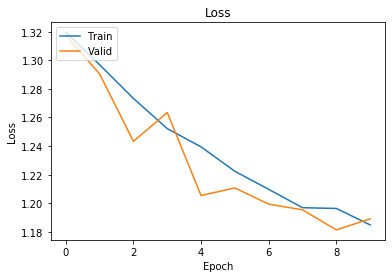

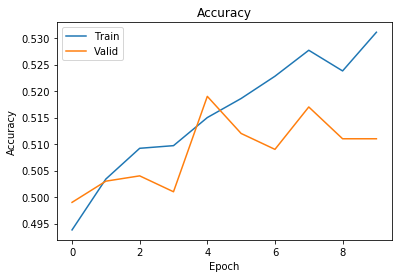

In [0]:
history = model.fit([inputs_train, queries_train], answers_train, batch_size, train_epochs,
          validation_data=([inputs_test, queries_test], answers_test))

plot_loss(history,"Loss")
plot_acc(history,"Accuracy")

model.save('model.h5')

## 1.6 Testing and Analysis

Now we need to actually make predictions and check the performance of our trained model with some examples:

In [0]:
for i in range(0,10):
        current_inp = test_stories[2*i]
        current_story, current_query, current_answer = vectorize_stories([current_inp], word_idx, story_maxlen, query_maxlen)
        current_prediction = model.predict([current_story, current_query])
        current_prediction = idx_word[np.argmax(current_prediction)]
        print(' '.join(current_inp[0]), ' '.join(current_inp[1]), '| Prediction:', current_prediction, '| Ground Truth:', current_inp[2])
        print("-----------------------------------------------------------------------------------------")


John travelled to the hallway . Mary journeyed to the bathroom . Where is John ? | Prediction: bathroom | Ground Truth: hallway
-----------------------------------------------------------------------------------------
John travelled to the hallway . Mary journeyed to the bathroom . Daniel went back to the bathroom . John moved to the bedroom . John went to the hallway . Sandra journeyed to the kitchen . Where is Sandra ? | Prediction: kitchen | Ground Truth: kitchen
-----------------------------------------------------------------------------------------
John travelled to the hallway . Mary journeyed to the bathroom . Daniel went back to the bathroom . John moved to the bedroom . John went to the hallway . Sandra journeyed to the kitchen . Sandra travelled to the hallway . John went to the garden . Sandra went back to the bathroom . Sandra moved to the kitchen . Where is Sandra ? | Prediction: kitchen | Ground Truth: kitchen
-------------------------------------------------------------

## 1.7 Custom Inputs

You can even write your example and test it with your model to see how powerful it is:

In [0]:
print('-------------------------------------------------------------------------------------------')
print('Custom User Queries (Make sure there are spaces before each word)')
while 1:
    print('-------------------------------------------------------------------------------------------')
    print('Please input a story')
    user_story_inp = input().split(' ')
    print('Please input a query')
    user_query_inp = input().split(' ')
    user_story, user_query, user_ans = vectorize_stories([[user_story_inp, user_query_inp, '.']], word_idx, story_maxlen, query_maxlen)
    user_prediction = model.predict([user_story, user_query])
    user_prediction = idx_word[np.argmax(user_prediction)]
    print('Result')
    print(' '.join(user_story_inp), ' '.join(user_query_inp), '| Prediction:', user_prediction)

In [0]:
# some examples:
# Mary went to the bathroom . John moved to the hallway . Mary travelled to the office . # Where is Mary ?
# Sandra travelled to the office . John journeyed to the garden .

As you understood how the model trained, please tell us about the pros and cons of the proposed model. How can we improve it if we want to use it in realistic task ? 

low accuray is a cons and fast training is cons of this model.
we can inlarge dataset and vocabulary and using NER and better vectorization methods!


# 2. Sentence Representation

We want to find out that we can classify a sentence according to the mean of its word embeddings or not. In this section, we will find the answer to the above statement.

Assume sentence $X = [\mathbf{x^{(1)}}, ..., \mathbf{x^{(N)}}]$ is given, then a sentence representation $\mathbf{R}$ can be calculated as following:

$$
\mathbf{R} = \frac{1}{N} \sum_{i=1}^{N} e_{x^{(i)}} \ \ \mathbf{R} \in \mathbb{R}^d
$$

where $e_{x^{(i)}}$ is an embedding vector for the token $x^{(i)}$.


Having such a simple model will enable us to analyze and understand its capabilities more easily. In addition, we will try one of the state-of-the-art text processing tools, called Flair, which can be run on GPUs. The task is text classification on the AG News corpus, which consists of news articles from more than 2000 news sources. Our split has 110K samples for the training and 10k for the validation set. Dataset examples are labeled with 4 major labels: `{World, Sports, Business, Sci/Tech}`

## 2.1 Preprocessing

Often, datasets in NLP come with unprocessed sentences. As a deep learning expert, you should be familiar with popular text processing tools such as NLTK, Spacy, Stanford CoreNLP, and Flair. Generally, text pre-processing in deep learning includes Tokenization, Vocabulary creation, and Padding. But here we want to do one more step, NER replacement. Basically, we want to replace named entities with their corresponding tags. For example "George Washington went to New York" will be converted to "\<PERSON> went to \<LOC>"

The purpose of this step is to reduce the size of vocabulary and support more words. This strategy is proved to be most beneficial when our dataset contains a large number of named entities, e.g. News dataset. 

Most pre-processing parts are implemented for you. You only need to fill the following function. Be sure to read the Flair documentations first.

In [0]:
! wget -q https://iust-deep-learning.github.io/972/static_files/assignments/asg04_assets/data.tar.gz
! tar xvfz data.tar.gz > /dev/null

from ag_news_util import read_ag_news, AG_NEWS_LBLS, create_model_input, create_vocab
! pip install -q tqdm flair
from tqdm import tqdm
from flair.data import Sentence
from flair.models import SequenceTagger
from IPython.display import SVG
from pprint import pprint
import numpy as np
import keras
from keras.models import Model
from keras.utils.vis_utils import model_to_dot
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
def get_tagged_string(sentence):
  """
  Join tokens and replace named enitites
  Args:
    sentence(flair.data.Sentence): An input sentence, containing list of tokens and their NER tag
    
  Returns:
    output(str): A String of sentence tokens separated by spaces and 
        each named enitity is replaced by its Tag
  
  Hint: Check out flair tutorials, https://github.com/zalandoresearch/flair/blob/master/resources/docs/TUTORIAL_2_TAGGING.md
      sentence.get_spans('ner'), sentence.tokens, token.idx and entity.tag might be helpful.
  """
  sent = sentence.to_plain_string()

  for entity in sentence.get_spans('ner'):
    sent = sent.replace(entity.text, ' <'+entity.tag+'> ')
  
  return " ".join(sent.split())

Test your implementation:

In [0]:
tagger = SequenceTagger.load('ner-ontonotes')
s = Sentence('tomorrow, Chad asks the IMF for a loan to pay for looking after more than 100,000 refugees from conflict-torn Darfur in western Sudan.', use_tokenizer=True)
tagger.predict(s)
s_ner = get_tagged_string(s)
print(s_ner == '<DATE> , <GPE> asks the <ORG> for a loan to pay for looking after <CARDINAL> refugees from conflict-torn <GPE> in western <GPE> .')
print(s_ner)

2020-01-31 09:17:57,812 loading file /root/.flair/models/en-ner-ontonotes-v0.4.pt
True
<DATE> , <GPE> asks the <ORG> for a loan to pay for looking after <CARDINAL> refugees from conflict-torn <GPE> in western <GPE> .


Define model's hyperparameters

In [0]:
VOCAB_SIZE = 10*1000
EMBEDDING_DIM = 300
NUM_CLASSES = 4
BATCH_SIZE = 512
MAX_LEN = 30

Process the entire corpus. It will approximately take 50 minutes. Please be patient. You may want to go for the next sections.

In [0]:
TAGGER_BATCH_SIZE = 512

if 'tagger' not in dir() or tagger is None:
  tagger = SequenceTagger.load('ner-ontonotes')

def precoess_sents(lst):
  output = []
  for i in tqdm(range(0, len(lst), TAGGER_BATCH_SIZE)):
    batch = [Sentence(x, use_tokenizer=True) for x in lst[i:i + TAGGER_BATCH_SIZE]]
    tagger.predict(batch, mini_batch_size=TAGGER_BATCH_SIZE, verbose=False)
    batch = [get_tagged_string(s).lower() for s in batch]
    output += batch
    
  return output

print("# Download and read dataset")
(train_sents, train_lbls), (valid_sents, valid_lbls) = read_ag_news()

print("\n# Replace named entities with their corresponding tags")
# We need to free the gpu memory due to some unknown bug in flair library
del tagger; tagger = SequenceTagger.load('ner-ontonotes')
import torch; torch.cuda.empty_cache()
train_sents_ner = precoess_sents(train_sents)
torch.cuda.empty_cache()

del tagger
tagger = SequenceTagger.load('ner-ontonotes')
torch.cuda.empty_cache()
valid_sents_ner = precoess_sents(valid_sents)
torch.cuda.empty_cache()

assert len(train_sents_ner) == len(train_lbls)
assert len(valid_sents_ner) == len(valid_lbls)

del tagger
tagger = SequenceTagger.load('ner-ontonotes')
torch.cuda.empty_cache()
del tagger

print("# Processed dataset sample")
print("train_sents[0] =", train_sents[0])
print("train_sents_ner[0] =", train_sents_ner[0])

# Download and read dataset

# Replace named entities with their corresponding tags
2020-01-31 09:18:15,201 loading file /root/.flair/models/en-ner-ontonotes-v0.4.pt


 47%|████▋     | 102/215 [7:42:13<8:27:55, 269.70s/it]

Create the embedding matrix

In [0]:
! wget "http://nlp.stanford.edu/data/glove.6B.zip" -O glove.6B.zip && unzip glove.6B.zip

word2vec = {}
with open('glove.6B.300d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    word2vec[word] =  np.asarray(values[1:], dtype='float32')

print('Found %s word vectors.' % len(word2vec))

In [0]:
# It is a good practice to initialize out-of-vocabulary tokens
# with the embeddings' mean
mean_embed = np.mean(np.array(list(word2vec.values())), axis=0)

# Create the embedding matrix according to our vocabulary
embedding_matrix = np.zeros((len(tok2id), EMBEDDING_DIM))
for word, i in tok2id.items():
  embedding_matrix[i] = word2vec.get(word, mean_embed)
  
print("embedding_matrix.shape =", embedding_matrix.shape)

In [0]:
# First create the vocabulary
vocab = create_vocab(train_sents_ner, VOCAB_SIZE)
tok2id = {w:i for i, w in enumerate(vocab)}

# It is a good practice to initialize out-of-vocabulary tokens
# with the embedding matrix mean
mean_embed = np.mean(np.array(list(word2vec.values())), axis=0)

# Create the embedding matrix according to the vocabulary
embedding_matrix = np.zeros((len(tok2id), EMBEDDING_DIM))
for word, i in tok2id.items():
  embedding_matrix[i] = word2vec.get(word, mean_embed)

# Fill index 0 with zero values: padding word vector
embedding_matrix[0] = np.zeros(shape=(EMBEDDING_DIM, ))

In [0]:
# Prepare the model input
x_train, y_train = create_model_input(train_sents_ner, tok2id, MAX_LEN), to_categorical(train_lbls, NUM_CLASSES)
x_valid, y_valid = create_model_input(valid_sents_ner, tok2id, MAX_LEN), to_categorical(valid_lbls, NUM_CLASSES)

## 2.2 Implementation

Let's build the model. As always Keras functional API is recommended. Numeber of layer as well as their dimensionality is totally up to you.

In [0]:
import keras
from keras import backend as K
from keras.layers import TimeDistributed,Conv1D,Dense,Embedding,Input,Dropout,LSTM,Bidirectional,MaxPooling1D,Flatten,concatenate

In [0]:
# We define one hypothetical layer as hint that can help you how to complete this class.

class BowModel(keras.Model):
  def __init__(self):
    super(BowModel, self).__init__(name='bow')
    
    self.model = Sequential()
    self.model.add(Embedding(max_features, output_dim=256))
    self.model.add(Dense(200), activation='relu')

  
  def call(self, words):
    
    """
    Args:
      words(Tensor): An input tensor for word ids with shape (?, MAX_LEN)
    """
    self.model.add(Embedding(words, output_dim=256))
    self.model.add(Dense(256,activation='relu'))

    
    return self.model

Creating model:

In [0]:
# Let's create and visualize the NER model
bow_model = BowModel()
bow_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['acc'])
SVG(model_to_dot(bow_model,show_shapes=True).create(prog='dot', format='svg'))

## 2.3 Training

In [0]:
# Train and visualize training
bow_model_hist = bow_model.fit(
    x_train, y_train, 
    batch_size=BATCH_SIZE, epochs=10, 
    validation_data=(x_valid, y_valid)
)
plot_acc(bow_model_hist, "Accracy of the model")
plot_loss(bow_model_hist, "Loss of the model")
bow_model.summary()

## 2.4 Analysis

An interactive shell is provided below. You can enter an input sequence to get the predicted label. The preprocessing functions will do the tokenization, thus don't worry about the spacing.

In [0]:
#@title Interactive Shell
if 'tagger' not in dir() or tagger is None:
  tagger = SequenceTagger.load('ner-ontonotes')

input_text = ""#@param {type:"string"}
input_sents_ner = precoess_sents([input_text])
input_tensor = create_model_input(input_sents_ner, tok2id, MAX_LEN)
pred_label = bow_model.predict(input_tensor)

print("\n-----\n\n    x: ", input_text)
print("x_ner: ", input_sents_ner[0])
print("\n   y': ", AG_NEWS_LBLS[np.argmax(pred_label[0])])

It is always helpful to see the confusion matrix:

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

yp_valid = bow_model.predict(x_valid)
yp_valid_ids = np.argmax(yp_valid, axis=1)
y_valid_ids = np.argmax(y_valid, axis=1)
print("\n# Classification Report")
print(classification_report(y_valid_ids, yp_valid_ids, target_names=AG_NEWS_LBLS))

print("# Confusion Matrix")
cm = confusion_matrix(y_valid_ids, yp_valid_ids)
plot_confusion_matrix(cm, AG_NEWS_LBLS, normalize=False)

Obviously, this is a relatively simple model. Hence it has limited modeling capabilities; Now it's time to find its mistakes. Can you fool the model by feeding a toxic example? Can you see the bag-of-word effect in its behavior? Write down the model limitation, Answers to the above questions, and keep in mind that you need to support each of your thoughts with an input/output example

$\color{red}{\text{Write your answer here}}$



# 3. Generating Text with Recurrent Neural Networks 

Recurrent neural networks can also be used as generative models. This means that in addition to being used for predictive models (making predictions) they can learn the sequences of a problem and then generate entirely new plausible sequences for the problem domain. Generative models are useful not only to study how well a model has learned a problem, but to learn more about the problem domain itself. In this part, we want to make a model which can generate texts with its gathered knowledge. 

We are going to learn the dependencies between words and the conditional probabilities of words in sequences, so that we can in turn generate wholly new and original sequences of characters. 

In [0]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku 
import numpy as np 
from IPython.display import SVG
from keras.utils import model_to_dot

tokenizer = Tokenizer()

Using TensorFlow backend.


## 3.1 Preprocessing 

Generation models and their experiments are not limited to text, we can also experiment with other data, such as computer source code, marked up documents in LaTeX, HTML or Markdown and more. As mentioned before, we want to work with text data in this section. Our dataset is raw english and simple text.

In [0]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-TnqUNtUwJwcGM6NmrcFnRxAhSs3fqKB' -O EngSentences.txt

--2020-01-30 19:05:51--  https://docs.google.com/uc?export=download&id=1-TnqUNtUwJwcGM6NmrcFnRxAhSs3fqKB
Resolving docs.google.com (docs.google.com)... 74.125.195.100, 74.125.195.139, 74.125.195.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-0c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/veria7trq6tmg98jnrhq9uq7shsg9pkk/1580407200000/04607754120182374769/*/1-TnqUNtUwJwcGM6NmrcFnRxAhSs3fqKB?e=download [following]
--2020-01-30 19:05:51--  https://doc-10-0c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/veria7trq6tmg98jnrhq9uq7shsg9pkk/1580407200000/04607754120182374769/*/1-TnqUNtUwJwcGM6NmrcFnRxAhSs3fqKB?e=download
Resolving doc-10-0c-docs.googleusercontent.com (doc-10-0c-docs.googleusercontent.com)... 74.125.20.132, 2607:f8b0:400e:c07::84
Connecting to doc-10-0c-docs.googleusercontent.com (doc-10-0c-do

Now we need to prepare the dataset ready for modeling:

In [0]:
def dataset_preparation(data):

	# basic cleanup
	corpus = data.lower().split("\n")

	# tokenization	
	tokenizer.fit_on_texts(corpus)
	all_words = len(tokenizer.word_index) + 1

	# create input sequences using list of tokens
	input_sequences = []
	for line in corpus:
		token_list = tokenizer.texts_to_sequences([line])[0]
		for i in range(1, len(token_list)):
			n_gram_sequence = token_list[:i+1]
			input_sequences.append(n_gram_sequence)

	# pad sequences 
	max_sequence_len = max([len(x) for x in input_sequences])
	input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

	# create inputs and labels
	inputs, labels = input_sequences[:,:-1],input_sequences[:,-1]
	labels = ku.to_categorical(labels, num_classes=all_words)

	return inputs, labels, max_sequence_len, all_words


## 3.2 Implementation and Training

Let's build the model. Using Keras framework is recommended. Number of layer as well as their dimensionality is totally up to you but the outview of the prefered model is saved for you.

In [0]:
def create_model(inputs, labels, max_sequence_len, all_words):
  model = Sequential()
  model.add(Embedding(all_words, max_sequence_len-1,input_length=max_sequence_len-1))
  model.add(LSTM(140,return_sequences=True))
  model.add(Dropout(0.5))
  model.add(LSTM(100))
  model.add(Dense(100,activation='relu'))
  model.add(Dense(all_words,activation='softmax'))

  model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
  model.summary()


  history = model.fit(inputs,labels,batch_size=32,validation_split=0.33,nb_epoch=500,verbose=1)

  return model, history

It's time to train the model and see the result. With big number of epochs, the training will take a long time. But the result will be better. So please be patient.

In [0]:
data = open('EngSentences.txt').read()
inputs, labels, max_sequence_len, all_words = dataset_preparation(data)
print(inputs.shape)
print(labels.shape)
print(max_sequence_len)
print((all_words))
print(len(data))



(4666, 21)
(4666, 893)
22
893
25846


In [0]:
data = open('EngSentences.txt').read()
inputs, labels, max_sequence_len, all_words = dataset_preparation(data)
model3,history3 = create_model(inputs, labels, max_sequence_len, all_words)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 21, 21)            18753     
_________________________________________________________________
lstm_9 (LSTM)                (None, 21, 140)           90720     
_________________________________________________________________
dropout_3 (Dropout)          (None, 21, 140)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               96400     
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 893)               90193     
Total params: 306,166
Trainable params: 306,166
Non-trainable params: 0
________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 3126 samples, validate on 1540 samples
Epoch 1/500
3126/3126 [==============================] - 12s 4ms/step - loss: 5.5381 - acc: 0.0966 - val_loss: 5.4096 - val_acc: 0.1013
Epoch 2/500
3126/3126 [==============================] - 9s 3ms/step - loss: 5.2231 - acc: 0.1046 - val_loss: 5.4953 - val_acc: 0.1013
Epoch 3/500
3126/3126 [==============================] - 9s 3ms/step - loss: 5.1061 - acc: 0.1075 - val_loss: 5.4208 - val_acc: 0.1013
Epoch 4/500
3126/3126 [==============================] - 9s 3ms/step - loss: 4.9325 - acc: 0.1222 - val_loss: 5.3419 - val_acc: 0.1636
Epoch 5/500
3126/3126 [==============================] - 9s 3ms/step - loss: 4.6414 - acc: 0.1740 - val_loss: 5.1098 - val_acc: 0.1656
Epoch 6/500
3126/3126 [==============================] - 9s 3ms/step - loss: 4.4575 - acc: 0.1763 - val_loss: 5.1858 - val_acc: 0.1753
Epoch 7/500
3126/3126 [==============================] - 9s 3ms/step - loss: 4.3132 - acc: 0.1878 - val_loss: 5.0535 - val_acc: 0.1799
Epoch 

This is the prefered model:

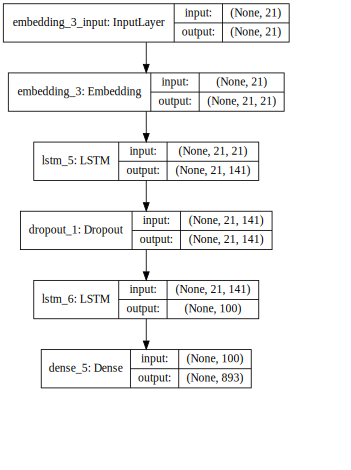

In [0]:
SVG(model_to_dot(model3,show_shapes= True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))

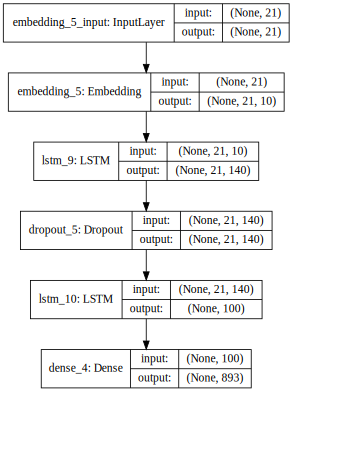

In [0]:
SVG(model_to_dot(model,show_shapes= True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))

## 3.3 Testing and Analysis

Finally, we need to actually make predictions and check the performance of our trained model.

The simplest way to make predictions is to first start off with a seed sequence as input, generate the next word, then update the seed sequence to add the generated word on the end and predict the new sequence. This process is repeated for as long as we want to predict new words.

We can pick a random input pattern as our seed text, then print generated words as we generate them.

In [0]:
def generate_text(seed_text, nums_of_next_words, max_sequence_len):
  output_text = []
  input_text = seed_text
  for i in range(nums_of_next_words):
    encoded_text = tokenizer.texts_to_sequences([input_text])[0]
    pad_encoded = pad_sequences([encoded_text], maxlen=max_sequence_len-1, truncating='pre')
    pred_word_ind = model3.predict_classes(pad_encoded,verbose=0)[0]
        
    pred_word = tokenizer.index_word[pred_word_ind]
    input_text += ' '+pred_word
    output_text.append(pred_word)


  return seed_text+" "+' '.join(output_text)

You can enter an input sequence of text to get the prediction according to the max length of sequence.

In [0]:
print (generate_text("naughty", 6, max_sequence_len))
print (generate_text("man is slicing an", 1, max_sequence_len))
print (generate_text("cat resting", 4, max_sequence_len))
print (generate_text("man riding skateboard", 3, max_sequence_len))
print (generate_text("woman frying", 3, max_sequence_len))
print (generate_text("black dog", 10, max_sequence_len))
print (generate_text("dancingnd three kids", 5, max_sequence_len))
print (generate_text("making sketch", 5, max_sequence_len))
print (generate_text("man", 5, max_sequence_len))

naughty is driving diced an air in
man is slicing an hair
cat resting people are driving four
man riding skateboard is man is
woman frying people are driving
black dog are driving four air in a pot is rocky paperwork
dancingnd three kids are eating the food and
making sketch people are ignoring the nearby
man is typing on a keyboard


In [0]:
model3.save('lstm_text_gen_model.h5')

In [0]:
print (generate_text("naughty", 6, max_sequence_len))
print (generate_text("man is slicing an", 1, max_sequence_len))
print (generate_text("cat resting", 4, max_sequence_len))
print (generate_text("man riding skateboard", 3, max_sequence_len))
print (generate_text("woman frying", 3, max_sequence_len))
print (generate_text("black dog", 10, max_sequence_len))
print (generate_text("dancingnd three kids", 5, max_sequence_len))
print (generate_text("making sketch", 5, max_sequence_len))
print (generate_text("man", 5, max_sequence_len))

naughty men are being man in a
man is slicing an onion
cat resting a man is playing
man riding skateboard is standing in
woman frying no man in
black dog is not playing a guitar and a man is standing
dancingnd three kids are being man in a
making sketch a man is no man
man is no man in a


Maybe you will face with the lots of repetitive words like $"man, is, playing, a, ..."$(depends on the number of epochs). 
So we need to encounter the problem of repetitive words and make the generated sentences meaningful. One simple way is to remove some of them.

In the next cells, remove some of the repetitive words from your data, then train the model. Compare the outputs with the previous model. 

In [0]:
# remove some words
delete_list = ["A ", " is", " a", "water", "playing"]

infile = "EngSentences.txt"
myfile = open(infile).read()
for w in delete_list:
  myfile = myfile.replace(w, '')
outfile = "mycleandata.txt"
f = open(outfile,'w')
f.write(myfile)

21680

Train the model again and see the outputs. In order to have better result, you can change the structure and hyperparameters of the model.

In [0]:
!./src/run_dataprep.sh data/train.json data/dev.json data/test.json

/bin/bash: ./src/run_dataprep.sh: No such file or directory


In [0]:
def create_model2(inputs, labels, max_sequence_len, all_words):
  model = Sequential()
  model.add(Embedding(all_words, max_sequence_len-1,input_length=max_sequence_len-1))
  model.add(LSTM(256))
  model.add(Dense(256,activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(all_words,activation='softmax'))

  model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])
  model.summary()


  history = model.fit(inputs,labels,batch_size=32,validation_split=0.33,nb_epoch=500,verbose=1)

  return model, history

def generate_text2(seed_text, nums_of_next_words, max_sequence_len):
  output_text = []
  input_text = seed_text
  for i in range(nums_of_next_words):
    encoded_text = tokenizer.texts_to_sequences([input_text])[0]
    pad_encoded = pad_sequences([encoded_text], maxlen=max_sequence_len-1, truncating='pre')
    pred_word_ind = model4.predict_classes(pad_encoded,verbose=0)[0]
        
    pred_word = tokenizer.index_word[pred_word_ind]
    input_text += ' '+pred_word
    output_text.append(pred_word)


  return seed_text+" "+' '.join(output_text)

In [0]:
data = open('mycleandata.txt').read()
inputs, labels, max_sequence_len, all_words = dataset_preparation(data)
model4, history4 = create_model2(inputs, labels, max_sequence_len, all_words)

In [0]:
print (generate_text2("man is slicing an", 1, max_sequence_len))
print (generate_text2("cat resting", 4, max_sequence_len))
print (generate_text2("man riding skateboard", 3, max_sequence_len))
print (generate_text2("woman frying", 3, max_sequence_len))
print (generate_text2("black dog", 10, max_sequence_len))
print (generate_text2("dancing and three kids", 5, max_sequence_len))
print (generate_text2("making sketch", 5, max_sequence_len))
print (generate_text2("man", 5, max_sequence_len))

man is slicing an steak
cat resting on chair which board
man riding skateboard in park in
woman frying chicken from frying
black dog sitting in the grassnd keeping its mouth closed closed road
dancing and three kids into the beach pool that
making sketch racing in lake ice field
man in car pulling up beside


As you can see, we can define different approaches, but there is still a lot of room for improvement. explain various ideas that may further improve the model that you could experiment.




**we can use attention for improvement! and bigger data also is good choice**